# Clustering

This notebook contains the code of the embedding clustering.
The aim is to find the best possible clustering of the embeddings to improve the efficiency (speed, accuracy) of chunk retrieval.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import warnings
import time

from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

/opt/anaconda3/envs/tdk_szakdoga/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Classes and functions

In [2]:
# -------------------------------
# 1️⃣ UMAP Dimensionality Reduction
# -------------------------------
def reduce_with_umap(embeddings, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42):
    """
    Reduce high-dimensional embeddings to low-dimensional space using UMAP.
    """
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state
    )
    return reducer.fit_transform(embeddings)


In [3]:
# -------------------------------
# 2️⃣ Clustering Function (Supports Multiple Methods)
# -------------------------------
def run_clustering(
    embeddings,
    method="dbscan",
    scale=True,
    **kwargs
):
    """
    Perform clustering using DBSCAN, KMeans, or Agglomerative.

    Args:
        embeddings: np.ndarray — input embeddings
        method: str — "dbscan", "kmeans", or "hierarchical"
        scale: bool — whether to standardize embeddings
        kwargs: dict — model-specific parameters

    Returns:
        labels: np.ndarray — cluster labels
        model: fitted model
    """
    if scale:
        embeddings = StandardScaler().fit_transform(embeddings)

    method = method.lower()
    if method == "dbscan":
        model = DBSCAN(**kwargs)
    elif method == "kmeans":
        model = KMeans(**kwargs)
    elif method == "hierarchical":
        model = AgglomerativeClustering(**kwargs)
    else:
        raise ValueError("Invalid method. Choose 'dbscan', 'kmeans', or 'hierarchical'.")

    labels = model.fit_predict(embeddings)
    return labels, model

In [4]:
def plot_clusters(umap_2d, labels, title="Clusters (UMAP 2D Projection)"):
    """
    Plot 2D embeddings with cluster labels using Plotly.
    """
    # Convert to numpy if needed
    umap_2d = np.array(umap_2d)
    labels = np.array(labels)

    # Create a dataframe for Plotly
    import pandas as pd
    df = pd.DataFrame({
        "UMAP-1": umap_2d[:, 0],
        "UMAP-2": umap_2d[:, 1],
        "Cluster": labels
    })

    # Plot
    fig = px.scatter(
        df,
        x="UMAP-1",
        y="UMAP-2",
        color="Cluster",
        color_continuous_scale="Spectral",
        title=title,
        hover_data=["Cluster"]
    )

    # Handle noise points (-1) if present
    if -1 in labels:
        df_noise = df[df["Cluster"] == -1]
        fig.add_scatter(
            x=df_noise["UMAP-1"],
            y=df_noise["UMAP-2"],
            mode="markers",
            marker=dict(color="black", size=6, opacity=0.5),
            name="Noise"
        )

    fig.update_traces(marker=dict(size=6, opacity=0.8))
    fig.update_layout(
        width=800,
        height=600,
        legend_title_text="Cluster ID"
    )
    fig.show()

In [5]:
# -------------------------------
# 4️⃣ Full Pipeline Wrapper
# -------------------------------
def cluster_and_plot(
    embeddings,
    df=None,
    cluster_method="dbscan",
    scale=True,
    cluster_params=None,
    umap_params=None,
    cluster_col_name="cluster",
    plot=True
):
    """
    Full pipeline: clustering + UMAP + optional visualization.

    Args:
        embeddings: np.ndarray — embedding matrix
        df: DataFrame (optional) — if provided, adds cluster labels
        cluster_method: "dbscan", "kmeans", "hierarchical"
        scale: bool — whether to standardize before clustering
        cluster_params: dict — model parameters (eps, n_clusters, etc.)
        umap_params: dict — UMAP params
        cluster_col_name: str — column name for cluster labels in df
        plot: bool — whether to visualize

    Returns:
        df_with_clusters (if df provided), labels, umap_2d
    """
    if cluster_params is None:
        cluster_params = {}
    if umap_params is None:
        umap_params = {}

    # 1️⃣ Run clustering
    labels, model = run_clustering(
        embeddings=embeddings,
        method=cluster_method,
        scale=scale,
        **cluster_params
    )
    print("Finished clustering.")

    # 2️⃣ UMAP projection
    umap_2d = reduce_with_umap(
        embeddings if not scale else StandardScaler().fit_transform(embeddings),
        **umap_params
    )
    print("Finished UMAP reduction.")

    # 3️⃣ Plot clusters
    if plot:
        title = f"{cluster_method.upper()} Clusters (UMAP Projection)"
        plot_clusters(umap_2d, labels, title=title)

    # 4️⃣ Save cluster labels to DataFrame
    if df is not None:
        df_out = df.copy()
        df_out[cluster_col_name] = labels
        return df_out, labels, umap_2d

    return labels, umap_2d

# Workflow

In [6]:
# Load data
X_semantic_train = np.load("./data/tensors/squad_train_v4_semantic_chunking_l2.npy")
df_semantic_train = pd.read_excel("./data/prepared/squad_train_v2_semantic_chunking.xlsx")
# X_semantic_val = np.load("./data/tensors/squad_val_v2_semantic_chunking.npy")
# df_semantic_val = pd.read_excel("./data/prepared/squad_val_v2_semantic_chunking.xlsx")

In [35]:
mask_train = df_semantic_train['context_id'] < 500
df_train = df_semantic_train[mask_train].copy()
X_train = X_semantic_train[mask_train.values]

In [54]:
df_clustered, labels, umap_2d = cluster_and_plot(
    embeddings=X_semantic_train,
    df=df_semantic_train,
    cluster_method="kmeans",
    cluster_params={"n_clusters": 600, "random_state": 42},
    umap_params={"n_neighbors": 15, "min_dist": 0.1}
)

Finished clustering.
Finished UMAP reduction.


Finished clustering.
Finished UMAP reduction.


<Axes: title={'center': 'Cluster Distribution'}, xlabel='cluster'>

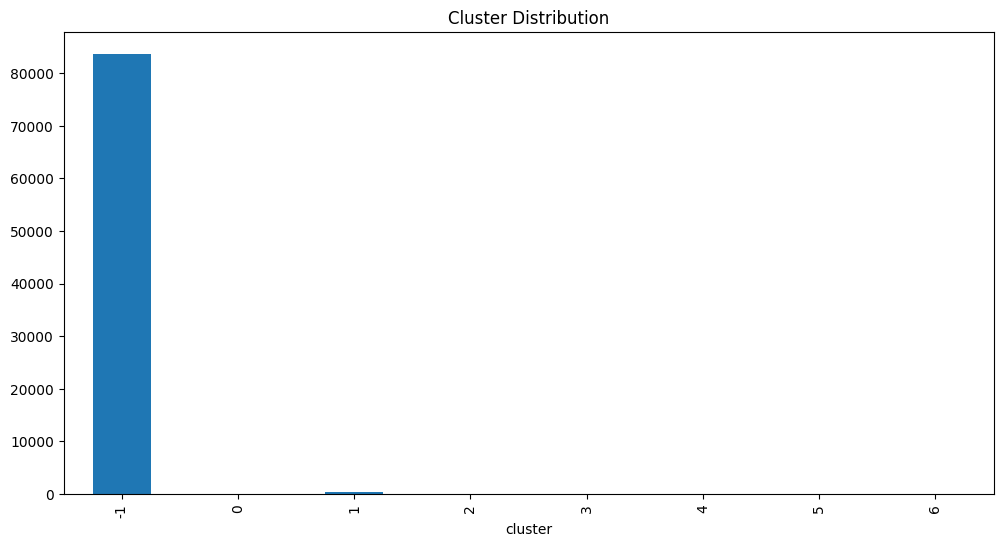

In [53]:
df_clustered, labels, umap_2d = cluster_and_plot(
    embeddings=X_semantic_train,
    df=df_semantic_train,
    cluster_method="dbscan",
    cluster_params={"eps": 0.45, "min_samples": 5, "metric": "euclidean"},
    umap_params={"n_neighbors": 15, "min_dist": 0.05}
)
df_clustered['cluster'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), title='Cluster Distribution')

In [51]:
df_clustered[df_clustered['cluster']!=-1].shape

(69975, 10)

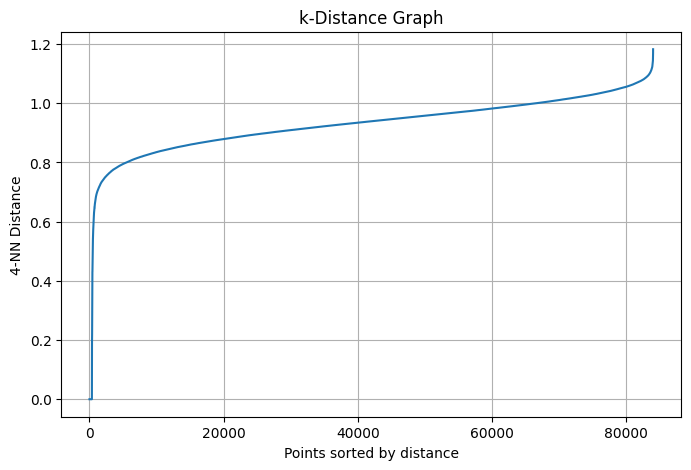

In [42]:
from sklearn.neighbors import NearestNeighbors

k = 4

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_semantic_train)
distances, indices = neighbors_fit.kneighbors(X_semantic_train)

distances = np.sort(distances[:, k-1])

# Plot the k-distance graph
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("k-Distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-NN Distance")
plt.grid(True)
plt.show()

In [10]:
X_semantic_train.shape

(84007, 1024)

100%|██████████| 16/16 [1:46:46<00:00, 400.40s/it]


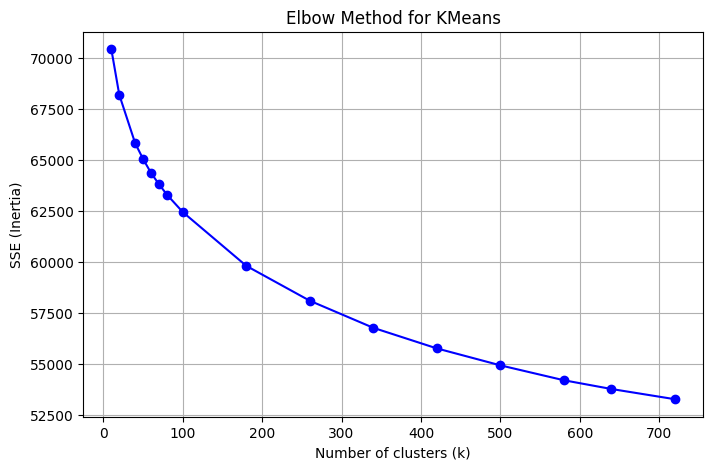

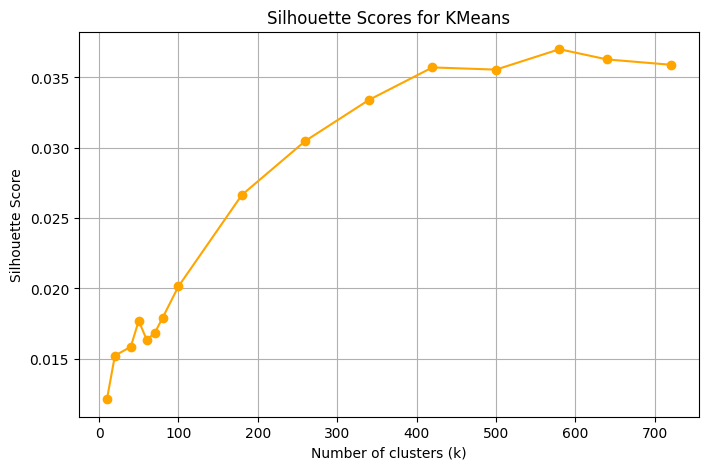

In [17]:
k_range = [10, 20, 40, 50, 60, 70, 80, 100, 180, 260, 340, 420, 500, 580, 640, 720]
sse = []
sil_scores = []

times = {}
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    start = time.time()
    labels = kmeans.fit_predict(X_semantic_train)
    end = time.time()
    # SSE (Elbow)
    sse.append(kmeans.inertia_)
    # Silhouette score
    sil_scores.append(silhouette_score(X_semantic_train, labels))
    times[k] = end - start


plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o', color='blue')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for KMeans")
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(k_range, sil_scores, marker='o', color='orange')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for KMeans")
plt.grid(True)
plt.show()

100%|██████████| 16/16 [24:42<00:00, 92.65s/it] 


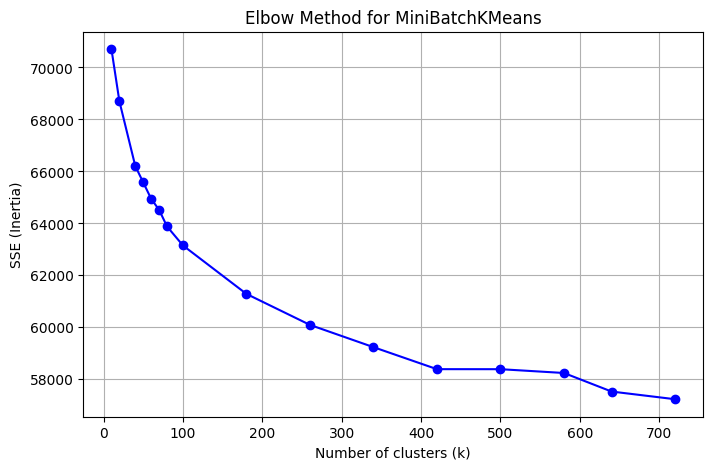

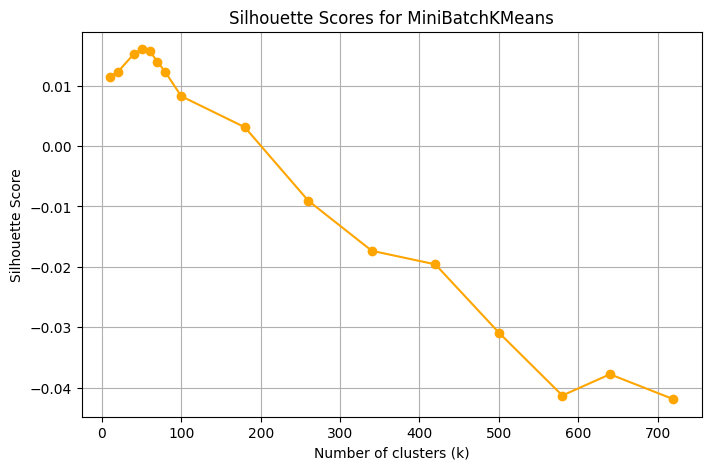

In [18]:
k_range = [10, 20, 40, 50, 60, 70, 80, 100, 180, 260, 340, 420, 500, 580, 640, 720]
sse = []
sil_scores = [] 

times = {}
for k in tqdm(k_range):
    mbk = MiniBatchKMeans(
        n_clusters=k, 
        random_state=42, 
        batch_size=1000,  # kisebb batch, gyorsabb futás
        n_init=10
    )
    start = time.time()
    labels = mbk.fit_predict(X_semantic_train)
    end = time.time()
    # SSE (Elbow)
    sse.append(mbk.inertia_)
    
    # Silhouette score
    sil_scores.append(silhouette_score(X_semantic_train, labels))

    times[k] = end - start

# Elbow plot
plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o', color='blue')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for MiniBatchKMeans")
plt.grid(True)
plt.show()

# Silhouette plot
plt.figure(figsize=(8,5))
plt.plot(k_range, sil_scores, marker='o', color='orange')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for MiniBatchKMeans")
plt.grid(True)
plt.show()

In [19]:
times

{10: 1.1608519554138184,
 20: 1.5050199031829834,
 40: 2.4809751510620117,
 50: 2.912616014480591,
 60: 3.2040340900421143,
 70: 3.6686508655548096,
 80: 4.072726011276245,
 100: 5.105151891708374,
 180: 8.435928106307983,
 260: 13.952023029327393,
 340: 15.371100902557373,
 420: 17.096246004104614,
 500: 20.283491134643555,
 580: 23.32666778564453,
 640: 26.262682914733887,
 720: 28.87387180328369}

In [9]:
#dbscan = DBSCAN(eps=13, min_samples=10)
#labels = dbscan.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=180, random_state=42)
labels = kmeans.fit_predict(X_semantic_train)

In [11]:
df_semantic_train['cluster'] = labels

In [12]:
df_semantic_train.to_excel("./data/labelled/squad_train_v2_semantic_chunking_clustered_kmeans180.xlsx", index=False)
#df_val.to_excel("./data/labelled/squad_val_v2_semantic_chunking_clustered.xlsx", index=False)

np.save("./data/labelled/squad_train_v2_semantic_chunking_clustered_kmeans180.npy", X_semantic_train)
#np.save("./data/labelled/squad_val_v2_semantic_chunking_clustered.npy", X_val)